# Preliminary tests - Gamma point source data

In [1]:
from hipecta.data import ctaTelescope2Matrix
from hipecta import core
import numpy as np
import h5py
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, ConcatDataset, sampler
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import hipecta.plots as plots
from torchvision import transforms, utils
import math
import time
import os
import sys

converter_path = os.path.abspath(os.path.join('/home/jacquemont/GammaLearn/converter_hdf5'))
if converter_path not in sys.path:
    sys.path.append(converter_path)
    
from converter_hdf5 import *
from datasets import *

In [2]:
def infer_energy_testset(model, test_loader):
    model.eval()
    y = np.empty((0, 1), np.double)
    y_inferred = np.empty((0, 1), np.double)

    for i, samples in enumerate(test_loader):

        ## Run on GPU ##
        if torch.cuda.is_available() and onGPU:
            #Load data as variable
            images = Variable(samples['image'].cuda())
            labels = Variable(samples['labels'].cuda())
        else:
            images = Variable(samples['image'])
            labels = Variable(samples['labels'])

   
        # forward pass
        outputs = model(images)
        y = np.append(y, labels.data[:,0].cpu().numpy())
        y_inferred = np.append(y_inferred, outputs.data.cpu().numpy())
    return y, y_inferred

In [3]:
def infer_impact_testset(model, test_loader):
    model.eval()
    y = np.empty((0, 2), np.double)
    y_inferred = np.empty((0, 2), np.double)

    for i, samples in enumerate(test_loader):

        ## Run on GPU ##
        if torch.cuda.is_available() and onGPU:
            #Load data as variable
            images = Variable(samples['image'].cuda())
            labels = Variable(samples['labels'].cuda())
        else:
            images = Variable(samples['image'])
            labels = Variable(samples['labels'])

   
        # forward pass
        outputs = model(images)

        y = np.concatenate((y, labels.data[:,3:5].cpu().numpy()))
        y_inferred = np.concatenate((y_inferred, outputs.data.cpu().numpy()))
    return y, y_inferred

In [4]:
class CNNModelLSTImpact(nn.Module):
    def __init__(self):
        super(CNNModelLSTImpact, self).__init__()
        # conv1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu1 = nn.ReLU()
        # maxpooling 1, by default floor
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # nn.AvgPool2d
        # batch norm
        self.batchnorm1 = nn.BatchNorm2d(16)
        
        # conv2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu2 = nn.ReLU()
        # maxpooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # batch norm
        self.batchnorm2 = nn.BatchNorm2d(32)
        
        # conv3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu3 = nn.ReLU()
        # maxpooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) # nn.AvgPool2d
        # batch norm
        self.batchnorm3 = nn.BatchNorm2d(64)
        
        # conv4
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu4 = nn.ReLU()
        # maxpooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) # nn.AvgPool2d
        # batch norm
        self.batchnorm4 = nn.BatchNorm2d(128)
        
        # conv5
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0)
        # non-linearity
        self.relu5 = nn.ReLU()
        
        # readout, regression of energy, altitude, azimuth, xCore, yCore
        #self.fc1 = nn.Linear(128, 5)
         # readout, regression of xCore and yCore
        self.fc1 = nn.Linear(128, 2)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform(m.weight.data, mode='fan_out')
                
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.batchnorm1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = self.batchnorm2(out)
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.maxpool3(out)
        out = self.batchnorm3(out)
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.maxpool4(out)
        out = self.batchnorm4(out)
        out = self.conv5(out)
        out = self.relu5(out)

        # Reshape out from 100,128,1 to 100,128
        out = out.view(out.size(0),-1)
        
        out = self.fc1(out)
        return out

In [5]:
class CNNModelLSTEnergy(nn.Module):
    def __init__(self):
        super(CNNModelLSTEnergy, self).__init__()
        # conv1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu1 = nn.ReLU()
        # maxpooling 1, by default floor
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # nn.AvgPool2d
        # batch norm
        self.batchnorm1 = nn.BatchNorm2d(16)
        
        # conv2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu2 = nn.ReLU()
        # maxpooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # batch norm
        self.batchnorm2 = nn.BatchNorm2d(32)
        
        # conv3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu3 = nn.ReLU()
        # maxpooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) # nn.AvgPool2d
        # batch norm
        self.batchnorm3 = nn.BatchNorm2d(64)
        
        # conv4
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu4 = nn.ReLU()
        # maxpooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) # nn.AvgPool2d
        # batch norm
        self.batchnorm4 = nn.BatchNorm2d(128)
        
        # conv5
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0)
        # non-linearity
        self.relu5 = nn.ReLU()
        
        # readout, regression of energy, altitude, azimuth, xCore, yCore
        #self.fc1 = nn.Linear(128, 5)
         # readout, regression of energy
        self.fc1 = nn.Linear(128, 1)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform(m.weight.data, mode='fan_out')
                
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.batchnorm1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = self.batchnorm2(out)
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.maxpool3(out)
        out = self.batchnorm3(out)
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.maxpool4(out)
        out = self.batchnorm4(out)
        out = self.conv5(out)
        out = self.relu5(out)

        # Reshape out from 100,128,1 to 100,128
        out = out.view(out.size(0),-1)
        
        out = self.fc1(out)
        return out

In [6]:
onGPU = True

test_file = '/home/jacquemont/projets_CTA/gamma0.hdf5'
f = h5py.File(test_file, 'r')
injTable = np.array(f['/Cameras/LSTCAM/injTable'])
nbRow = f['/Cameras/LSTCAM'].attrs['nbRow']
nbCol = f['/Cameras/LSTCAM'].attrs['nbCol']
test_dataset = LSTCamDataset(hdf5_file=f,
                             transform=transforms.Compose([
                                 TelescopeToSquareMatrix(injTable, nbRow, nbCol),
                                 ToTensor()
                             ]))

test_dataset_2 = LSTCamDataset(hdf5_file=f)

test_dataset_3 = ConcatDataset([test_dataset, test_dataset_2])


In [7]:
# Creation of subset train and test
random_indices = torch.randperm(len(test_dataset))
train_max_index = int(len(test_dataset)*0.9)
train_set_sampler = sampler.SubsetRandomSampler(random_indices[0:train_max_index])
test_set_sampler = sampler.SubsetRandomSampler(random_indices[train_max_index + 1:])

batch_size = 16
n_iters = 12000
num_epochs = int(n_iters/(len(test_dataset)*0.9/batch_size))
print(num_epochs)

# iterable subset creation
train_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           sampler=train_set_sampler)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          sampler=test_set_sampler)

21


In [8]:
if torch.cuda.is_available():
    print("CUDA available")

CUDA available


## Energy

In [9]:
model1 = torch.load(f='/home/jacquemont/MyDriveAtLap/saved_models/model1_kaimin-uniform_batchnorm_lr0.001_20epochs_mseloss.tar')
model2 = torch.load(f='/home/jacquemont/MyDriveAtLap/saved_models/model1_kaimin-uniform_batchnorm_lr0.0001_20epochs_mseloss.tar')
model3 = torch.load(f='/home/jacquemont/MyDriveAtLap/saved_models/model1_kaimin-uniform_batchnorm_lr0.00001_20epochs_mseloss.tar')
model4 = torch.load(f='/home/jacquemont/MyDriveAtLap/saved_models/model1_kaimin-uniform_batchnorm_lr0.002_20epochs_mseloss.tar')
model5 = torch.load(f='/home/jacquemont/MyDriveAtLap/saved_models/model1_kaimin-uniform_batchnorm_lr0.0005_20epochs_mseloss.tar')
model6 = torch.load(f='/home/jacquemont/MyDriveAtLap/saved_models/model1_kaimin-uniform_batchnorm_lr0.00005_20epochs_mseloss.tar')


In [10]:
m1 = CNNModelLSTEnergy()
m1.load_state_dict(model1['model'])
m1.double()
m1.cuda()
y1, y1_inferred = infer_energy_testset(m1, test_loader)
m2 = CNNModelLSTEnergy()
m2.load_state_dict(model2['model'])
m2.double()
m2.cuda()
y2, y2_inferred = infer_energy_testset(m2, test_loader)
m3 = CNNModelLSTEnergy()
m3.load_state_dict(model3['model'])
m3.double()
m3.cuda()
y3, y3_inferred = infer_energy_testset(m3, test_loader)
m4 = CNNModelLSTEnergy()
m4.load_state_dict(model4['model'])
m4.double()
m4.cuda()
y4, y4_inferred = infer_energy_testset(m4, test_loader)
m5 = CNNModelLSTEnergy()
m5.load_state_dict(model5['model'])
m5.double()
m5.cuda()
y5, y5_inferred = infer_energy_testset(m5, test_loader)
m6 = CNNModelLSTEnergy()
m6.load_state_dict(model6['model'])
m6.double()
m6.cuda()
y6, y6_inferred = infer_energy_testset(m6, test_loader)

### Loss evolution

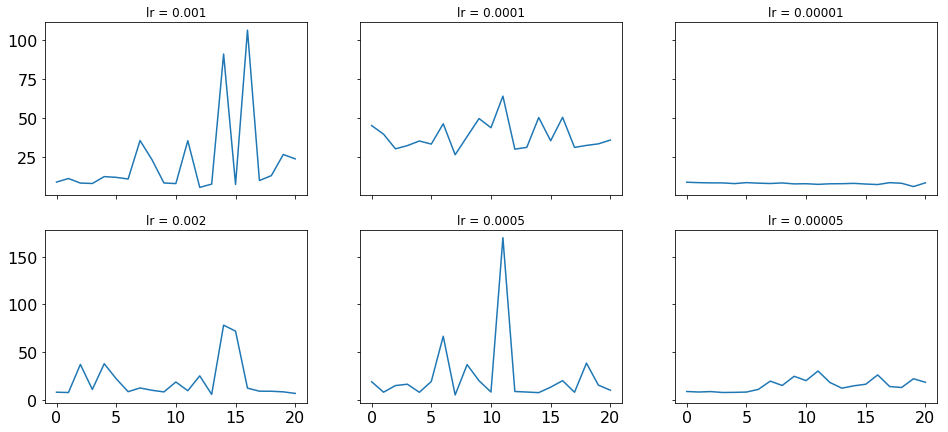

In [11]:
f, ((fig1, fig2, fig3), (fig4, fig5, fig6)) = plt.subplots(2, 3, sharex='col', sharey='row')
fig1.plot(model1['loss_epoch'])
fig1.set_title('lr = 0.001')
fig2.plot(model2['loss_epoch'])
fig2.set_title('lr = 0.0001')
fig3.plot(model3['loss_epoch'])
fig3.set_title('lr = 0.00001')
fig4.plot(model4['loss_epoch'])
fig4.set_title('lr = 0.002')
fig5.plot(model5['loss_epoch'])
fig5.set_title('lr = 0.0005')
fig6.plot(model6['loss_epoch'])
fig6.set_title('lr = 0.00005')
f.set_figheight(7)
f.set_figwidth(16)
plt.show()

### Migration matrix of true and reconstructed energy

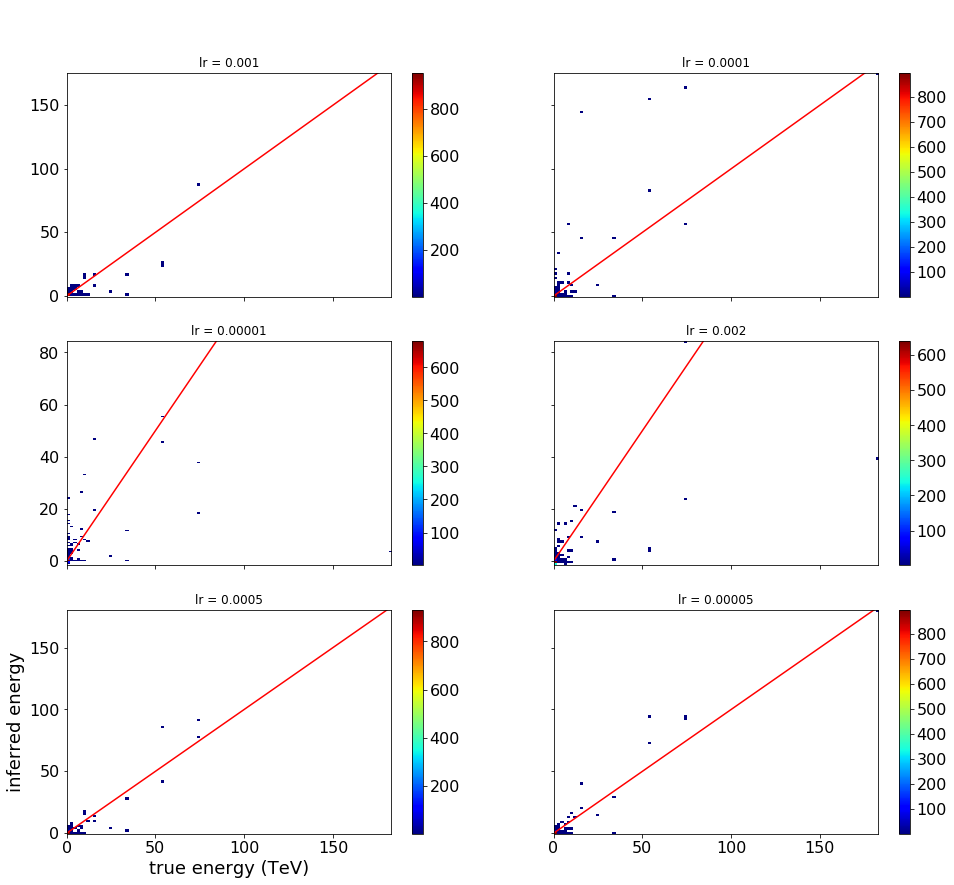

In [19]:
#histogram definition
bins = [100,100] # number of bins

cm = plt.cm.jet
cm.set_under('w',1)

# histogram the data
f, ((fig1, fig2), (fig3, fig4), (fig5, fig6)) = plt.subplots(3, 2, sharex='col', sharey='row')

_, _, _, im1 = fig1.hist2d(y1, y1_inferred, bins=bins, cmap=cm, cmin=1)
fig1.plot([-500, 0, 500], [-500, 0, 500],'r')
fig1.set_title('lr = 0.001')
_, _, _, im2 = fig2.hist2d(y2, y2_inferred, bins=bins, cmap=cm, cmin=1)
fig2.plot([-500, 0, 500], [-500, 0, 500],'r')
fig2.set_title('lr = 0.0001')
_, _, _, im3 = fig3.hist2d(y3, y3_inferred, bins=bins, cmap=cm, cmin=1)
fig3.plot([-500, 0, 500], [-500, 0, 500],'r')
fig3.set_title('lr = 0.00001')
_, _, _, im4 = fig4.hist2d(y4, y4_inferred, bins=bins, cmap=cm, cmin=1)
fig4.plot([-500, 0, 500], [-500, 0, 500],'r')
fig4.set_title('lr = 0.002')
fig5.set_ylabel('inferred energy')
_, _, _, im5 = fig5.hist2d(y5, y5_inferred, bins=bins, cmap=cm, cmin=1)
fig5.plot([-500, 0, 500], [-500, 0, 500],'r')
fig5.set_title('lr = 0.0005')
_, _, _, im6 = fig6.hist2d(y6, y6_inferred, bins=bins, cmap=cm, cmin=1)
fig6.plot([-500, 0, 500], [-500, 0, 500],'r')
fig6.set_title('lr = 0.00005')

fig5.set_xlabel('true energy (TeV)')
f.colorbar(im1, ax=fig1)   
f.colorbar(im2, ax=fig2)
f.colorbar(im3, ax=fig3)
f.colorbar(im4, ax=fig4)
f.colorbar(im5, ax=fig5)
f.colorbar(im6, ax=fig6)
f.set_figwidth(16)
f.set_figheight(14)
plt.show()

## Impact position

In [13]:
model7 = torch.load(f='/home/jacquemont/MyDriveAtLap/saved_models/model1_impactPos_kaimin-uniform_batchnorm_lr0.0001_20epochs_mseloss.tar')
model8 = torch.load(f='/home/jacquemont/MyDriveAtLap/saved_models/model1_impactPos_kaimin-uniform_batchnorm_lr0.00001_20epochs_mseloss.tar')
model9 = torch.load(f='/home/jacquemont/MyDriveAtLap/saved_models/model1_impactPos_kaimin-uniform_batchnorm_lr0.00005_20epochs_mseloss.tar')


In [14]:
m7 = CNNModelLSTImpact()
m7.load_state_dict(model7['model'])
m7.double()
m7.cuda()
y7, y7_inferred = infer_impact_testset(m7, test_loader)
m8 = CNNModelLSTImpact()
m8.load_state_dict(model8['model'])
m8.double()
m8.cuda()
y8, y8_inferred = infer_impact_testset(m8, test_loader)
m9 = CNNModelLSTImpact()
m9.load_state_dict(model9['model'])
m9.double()
m9.cuda()
y9, y9_inferred = infer_impact_testset(m9, test_loader)

### Loss evolution

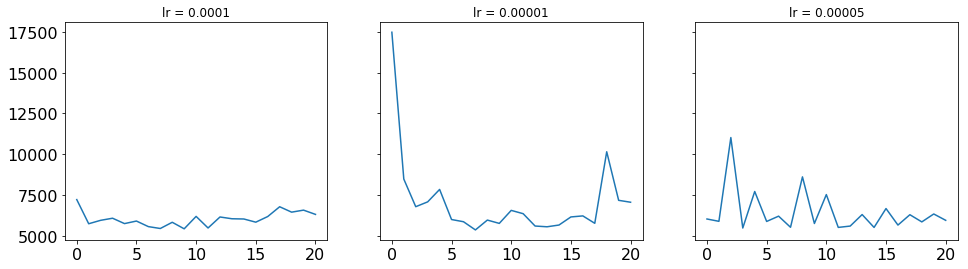

In [15]:
f, (fig1, fig2, fig3) = plt.subplots(1, 3, sharex='col', sharey='row')
fig1.plot(model7['loss_epoch'])
fig1.set_title('lr = 0.0001')
fig2.plot(model8['loss_epoch'])
fig2.set_title('lr = 0.00001')
fig3.plot(model9['loss_epoch'])
fig3.set_title('lr = 0.00005')
f.set_figheight(4)
f.set_figwidth(16)
plt.show()

### Migration matrix of true and reconstructed impact point (xCore and yCore)

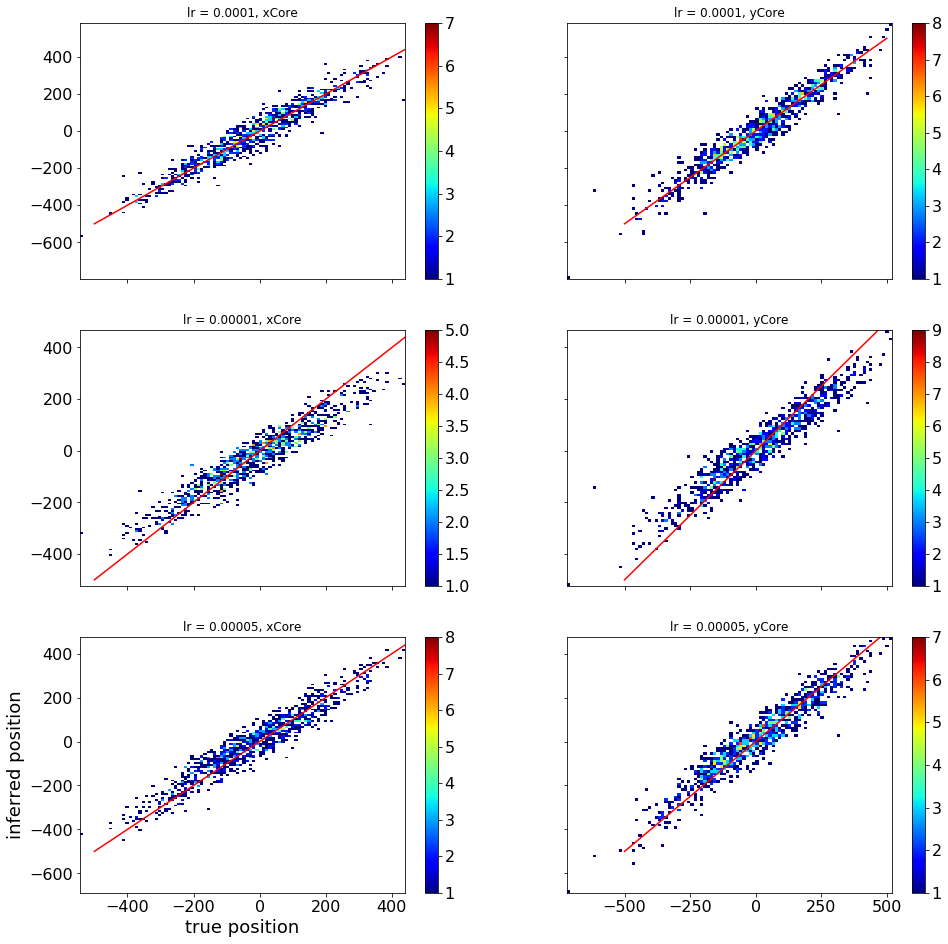

In [16]:
#histogram definition
bins = [100,100] # number of bins

cm = plt.cm.jet
cm.set_under('w',1)

# histogram the data
f, ((fig1, fig2), (fig3, fig4), (fig5, fig6)) = plt.subplots(3, 2, sharex='col', sharey='row')

_, _, _, im1 = fig1.hist2d(y7[:,0], y7_inferred[:,0], bins=bins, cmap=cm, cmin=1)
fig1.plot([-500, 0, 500], [-500, 0, 500],'r')
fig1.set_title('lr = 0.0001, xCore')
_, _, _, im2 = fig2.hist2d(y7[:,1], y7_inferred[:,1], bins=bins, cmap=cm, cmin=1)
fig2.plot([-500, 0, 500], [-500, 0, 500],'r')
fig2.set_title('lr = 0.0001, yCore')
_, _, _, im3 = fig3.hist2d(y8[:,0], y8_inferred[:,0], bins=bins, cmap=cm, cmin=1)
fig3.plot([-500, 0, 500], [-500, 0, 500],'r')
fig3.set_title('lr = 0.00001, xCore')
_, _, _, im4 = fig4.hist2d(y8[:,1], y8_inferred[:,1], bins=bins, cmap=cm, cmin=1)
fig4.plot([-500, 0, 500], [-500, 0, 500],'r')
fig4.set_title('lr = 0.00001, yCore')
fig5.set_ylabel('inferred position')
_, _, _, im5 = fig5.hist2d(y9[:,0], y9_inferred[:,0], bins=bins, cmap=cm, cmin=1)
fig5.plot([-500, 0, 500], [-500, 0, 500],'r')
fig5.set_title('lr = 0.00005, xCore')
_, _, _, im6 = fig6.hist2d(y9[:,1], y9_inferred[:,1], bins=bins, cmap=cm, cmin=1)
fig6.plot([-500, 0, 500], [-500, 0, 500],'r')
fig6.set_title('lr = 0.00005, yCore')

fig5.set_xlabel('true position')
f.colorbar(im1, ax=fig1)   
f.colorbar(im2, ax=fig2)
f.colorbar(im3, ax=fig3)
f.colorbar(im4, ax=fig4)
f.colorbar(im5, ax=fig5)
f.colorbar(im6, ax=fig6)
f.set_figwidth(16)
f.set_figheight(16)
plt.show()

In [ ]:
f.close()